In [132]:
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns 
import random as rnd 
plt.style.use('seaborn-dark-palette')
plt.rcParams.update({'font.size':12})

In [133]:
from histogram_utils import pdf_const_bin , histogram
from probability_utils import calc_likelihood , gen_rand_n , gen_samples

## Defining electron scattering distribution

After Normalisation :

$p(cos\theta) = N\times (1+\alpha* cos^2(\theta))$

$N  = 1/(2*(1+\frac{\alpha}{3}))$ 

In [134]:
def scatter_dist(alpha):
    def to_return(x):
        N = 2*(1+alpha/3)
        val = (1+alpha*(x**2))/N
        return val
    return to_return



## Simulating experiment
This function generates  N samples for the given pdf , corresponding to given $\alpha$  

In [135]:
def simulate_scatter(alpha , N):
    y_max = (1+alpha)/(2*(1+alpha/3))
    y = gen_samples(scatter_dist(alpha) , -1 , 1 , y_max , N)
    return y

Generating 500 , and 4000 samples corrsponding to $\alpha = 5.5$

In [136]:
alpha = 5.5
N_1 , N_2 = 500 ,  4000 
y_1 = simulate_scatter(alpha , N_1)
y_2 = simulate_scatter(alpha , N_2)

In [137]:
data = np.loadtxt('list' , delimiter=',')

In [138]:
dist_1 , bins_1 = pdf_const_bin(y_1 , 20)
width_1 = bins_1[1]-bins_1[0]

dist_2 , bins_2 = pdf_const_bin(y_2 , 20)
width_2 = bins_2[1]-bins_2[0]

dist_obs , bins_obs = pdf_const_bin(data , 20)
width_obs = bins_obs[1]-bins_obs[0]

x = np.linspace(-1,1,20)
y_th = scatter_dist(alpha)(x)

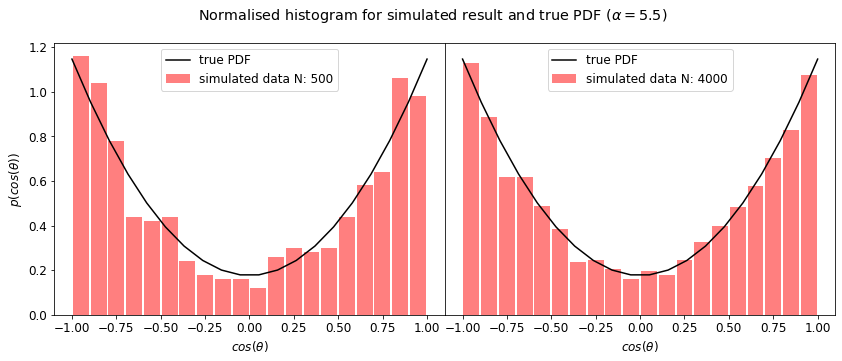

In [139]:
from matplotlib import  gridspec as gs
fig  = plt.figure(figsize=(14,5))
spec = gs.GridSpec(ncols=2 , nrows=1 ,  wspace=0)
ax1 = fig.add_subplot(spec[0,0])
ax2 = fig.add_subplot(spec[0,1] , sharey=ax1)
#ax3 = fig.add_subplot(spec[0,2])

ax1.bar(bins_1, dist_1 ,  width=width_1-0.01 , color='red' , alpha = 0.5 )
ax1.plot(x ,y_th , color='k')
ax1.legend(['true PDF' , 'simulated data N: 500'])
ax1.set_ylabel(r'$p(cos(\theta))$')
ax1.set_xlabel(r'$cos(\theta)$')
ax2.bar(bins_2, dist_2 ,  width=width_2-0.01 , color='red' , alpha = 0.5 )
ax2.plot(x ,y_th , color='k')
ax2.yaxis.set_visible(False)
ax2.set_xlabel(r'$cos(\theta)$')
ax2.legend(['true PDF' , 'simulated data N: 4000'])
fig.suptitle(r'Normalised histogram for simulated result and true PDF $(\alpha=5.5)$')
plt.show()

In [140]:
alpha_itr = np.linspace(0 , 25 , num=250 , endpoint=True )
ll_1 , ll_2 , ll_obs = [] , [] , []

for a in alpha_itr:
    ll_1.append(calc_likelihood(scatter_dist(a) , y_1))
    ll_2.append(calc_likelihood(scatter_dist(a) , y_2))
    ll_obs.append(calc_likelihood(scatter_dist(a) , data))


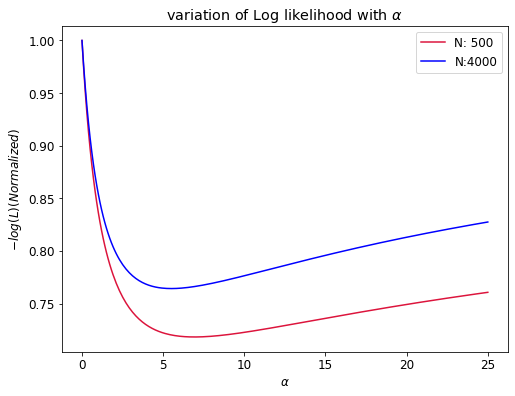

In [141]:
plt.figure(figsize=(8,6))
plt.plot(alpha_itr , ll_1/np.amin(ll_1) , color='crimson')
plt.plot(alpha_itr , ll_2/np.amin(ll_2) , color= 'blue')
plt.legend(['N: 500','N:4000' , 'observed data'])
plt.title(r'variation of Log likelihood with $\alpha$')
plt.ylabel(r'$-log(L) (Normalized)$')
plt.xlabel(r'$\alpha$')
#plt.xscale('log')
plt.show()

## Maximizing Log Likelihood
We will find value of alpha which correspond to Maximum of log likelihood corresponding to the cases

(given data , simulated data for N=500 , simulated data for N=4000)

### For maximization 
> Method used :
parameter update is scaled by the gradient at the given point and in the direction of gradient at the given point  , hence step size is adaptive to the gradient and can reach maxima faster without overshooting it. gardients are calulated only till we finds (almost) zero gradient.

$p_{next} = p_{prev}+\nabla_p(-log(L)) \times \Delta p$ 

Following function is a more generalized function which allows us to calculate either maximas or minimas of likelihood corresponding to given PDF

In [142]:
def find_extrema(pdf , d , p_min , p_max , type):
    p = p_min
    del_p = 0.1
    prev = calc_likelihood(scatter_dist(p) , d)
    nxt = calc_likelihood(scatter_dist(p+del_p) , d)
    grad = (nxt-prev)/del_p
    
    while(abs(grad)>1e-4):
        prev = calc_likelihood(scatter_dist(p) , d)
        nxt = calc_likelihood(scatter_dist(p+del_p) , d)
        #grd_prev = grad
        grad = (nxt-prev)/del_p
        del_p = 0.1
        if(type=='min'):
            p = p-(grad)*del_p
        elif(type=='max'):
            p = p+(grad)*del_p
        else:
            raise (ValueError('type must be "min" or "max"'))
        #print(p)
    return p 


In [143]:
a_max_given_data = (find_extrema(scatter_dist ,data , 0 , 20 , type='max'))
a_max_data_500 = (find_extrema(scatter_dist ,y_1 , 0 , 20 , type='max'))
a_max_data_4000 = (find_extrema(scatter_dist ,y_2 , 0 , 20 , type= 'max'))


In [145]:
print('By maximum Likelihood , parameters estimated')
print('_______________________________________________')
print('alpha for simulated data (500): {:.4f}'.format(a_max_data_500))
print('alpha estimated for simulated data(4000): {:.4f}'.format(a_max_data_4000))
print('alpha estimated for given data: {:.4f}'.format(a_max_given_data))

By maximum Likelihood , parameters estimated
_______________________________________________
alpha for simulated data (500): 6.8796
alpha estimated for simulated data(4000): 5.4569
alpha estimated for given data: 5.4332


## Uncrtainity estimation
 Around Maxima such that 

 $\sigma_a$ correspond to $\Delta M = 1/2$ , 

 Where $M = log(likelihood)$

 Method :
Varying parameter $\alpha$ by $\Delta \alpha$ on both sides such that $\Delta M = 1/2$  

In [146]:
def cal_uncertanity(fn , data , param_min , param_max , err_side = 'left'):
    d_a = 0.001
    delta_a = 0.0
    a = find_extrema(fn , data , param_min , param_max, type='max' )
    m_max = calc_likelihood(fn(a) , data)
    a = a+d_a
    m_cal = calc_likelihood(fn(a) , data)
    delta_m = m_max-m_cal
    while(delta_m < 0.5):
        if(err_side=='right'):
            a = a + d_a
            delta_a += d_a 
        elif(err_side=='left'):
            a = a - d_a
            delta_a -=d_a
        m_cal = calc_likelihood(fn(a) , data)
        delta_m = m_max - m_cal
        #print(delta_m)
    return delta_a-d_a


In [147]:
err_a_sim_500_l = cal_uncertanity(scatter_dist , y_1 , 0 , 20 , err_side = 'left')
err_a_sim_500_r = cal_uncertanity(scatter_dist , y_1 , 0 , 20 , err_side = 'right')
print('Uncertnity in alpha:for N=500')
print('{:.3f} , {:.3f}'.format(err_a_sim_500_l , err_a_sim_500_r))

Uncertnity in alpha:for N=500
-1.214 , 1.641


In [131]:
err_a_sim_4000_l = cal_uncertanity(scatter_dist , y_2 , 0 , 20 , err_side = 'left')
err_a_sim_4000_r = cal_uncertanity(scatter_dist , y_2 , 0 , 20 , err_side = 'right')
print('Uncertnity in alpha:for N=4000')
print('{:.3f} , {:.3f}'.format(err_a_sim_4000_l , err_a_sim_4000_r))

Uncertnity in alpha:for N=4000
-0.348 , 0.475


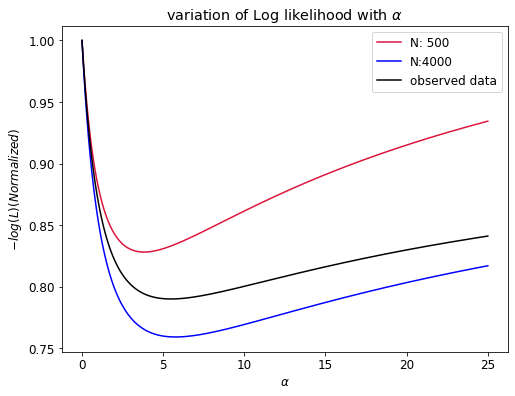

In [129]:
plt.figure(figsize=(8,6))
plt.plot(alpha_itr , ll_1/np.amin(ll_1) , color='crimson')
plt.plot(alpha_itr , ll_2/np.amin(ll_2) , color= 'blue')
plt.plot(alpha_itr , ll_obs/np.amin(ll_obs) , color= 'black')
plt.legend(['N: 500','N:4000' , 'observed data'])
plt.title(r'variation of Log likelihood with $\alpha$')
plt.ylabel(r'$-log(L) (Normalized)$')
plt.xlabel(r'$\alpha$')
#plt.xscale('log')
plt.show()

## Result

| (data) | (Parameter$\alpha$) | ($\Delta M = 0.5$ interval) |
| --- | --- | --- |
| N:500 | 6.8796 | -1.214 , 1.641 |
| N:4000| 5.4569 | -0.348 , 0.475 |